<a href="https://colab.research.google.com/github/hwankang/chemometrics-tutorials/blob/master/Chemometrics_08_29_univariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/hwankang/chemometrics-tutorials

Cloning into 'chemometrics-tutorials'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 183 (delta 86), reused 86 (delta 40), pack-reused 40
Receiving objects: 100% (183/183), 24.42 MiB | 17.88 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [2]:
%cd chemometrics-tutorials
!pip install -r requirements.txt

/content/chemometrics-tutorials
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 8.1 MB/s 


In [3]:
import numpy as np
from sklearn import preprocessing
import pandas as pds
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from statsmodels.stats.multitest import multipletests

from pyChemometrics.plotting_utils import manhattan_plot, interactive_manhattan
from pyChemometrics.plotting_utils import _lineplots as Lineplot

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
# Load the dataset
X = pds.read_csv("./data/X_spectra.csv",dtype=None).values
Y = pds.read_csv("./data/worm_yvars.csv",delimiter=',',dtype=None)
ppm = np.loadtxt("./data/ppm.csv",delimiter=',')

# Use pandas Categorical type to generate the dummy enconding of the Y vector (0 and 1) 
Y1 = pds.Categorical(Y.iloc[:, 0]).codes
Y2 = pds.Categorical(Y.iloc[:, 1]).codes

In [5]:
dataset = pds.DataFrame(X)
dataset.insert(0, 'Y', Y1)
dataset.insert(1, 'Y2', Y2)

# Prepare the dataframe for use with model fitting
dataset.columns = dataset.columns.astype(str)
varnames = 'ppm_' + dataset.columns[2::]
newnames = ['Genotype', 'Age']
newnames.extend(varnames)
dataset.columns = newnames

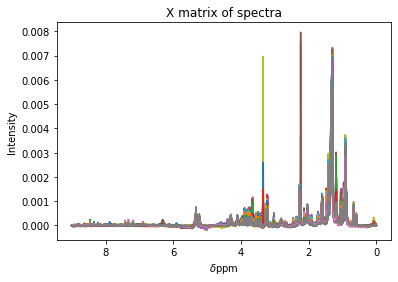

In [6]:
# Plot the dataset
plt.figure()
plt.plot(ppm, X.T)
plt.title("X matrix of spectra")
plt.xlabel("$\delta$ppm")
plt.gca().invert_xaxis()
plt.ylabel("Intensity")
plt.show()

In [7]:
# Lists to store the information
# p-value for the genotype effect
pval_genonly = list()
# regression coefficient for the genotype effect
beta_genonly = list()
# P-value for the F-test 
fpval_genonly = list()
# r2 for the regression model
r2_genonly = list()

# Fit each column with a spectral variable
for curr_variable in dataset.iloc[:, 2:]:
    # Formula for current variable 
    fm = curr_variable + ' ~ C(Genotype)'
    mod = smf.ols(formula = fm, data=dataset)
    res = mod.fit()
    pval_genonly.append(res.pvalues[1])
    beta_genonly.append(res.params[1])
    fpval_genonly.append(res.f_pvalue)
    r2_genonly.append(res.rsquared)
    
pval_genonly = np.array(pval_genonly)
beta_genonly = np.array(beta_genonly)
r2_genonly = np.array(r2_genonly)
fpval_genonly = np.array(fpval_genonly)

In [8]:
# Generate lists to store the results for each varable. 


# beta_gen = the values for the regression coefficient associated with age
# pval_gen = the p-value for the t-test
# beta_age = the values for the age regression coefficients 
# pval_age = the p-values for the age regression coefficient 

# r2 = r-squared value for the entire regression model
# fpval = the p-value for the F-test of the model's r-squared

pval_gen = list()
pval_age = list()
beta_gen = list()
beta_age = list()
fpval = list()
r2 = list()

for curr_variable in dataset.iloc[:, 2:]:
    # Fit each column
    fm = curr_variable + ' ~ C(Genotype) + C(Age)'
    mod = smf.ols(formula = fm, data=dataset)
    res = mod.fit()
    pval_gen.append(res.pvalues[1])
    pval_age.append(res.pvalues[2])
    beta_gen.append(res.params[1])
    beta_age.append(res.params[2])
    fpval.append(res.f_pvalue)
    r2.append(res.rsquared)
    
pval_gen = np.array(pval_gen)
beta_gen = np.array(beta_gen)
pval_age = np.array(pval_age)
beta_age = np.array(beta_age)
r2 = np.array(r2)
fpval = np.array(fpval)

# Multiple testing correction

In [9]:
# Adjusting the first analysis without age
by_res_gen_only = multipletests(pval_genonly, alpha=0.05, method='fdr_by')
p_genonly_byadj = by_res_gen_only[1]

In [10]:
# Adjusting the analysis with genotype and age
by_res_gen = multipletests(pval_gen, alpha=0.05, method='fdr_by')
p_gen_byadj = by_res_gen[1]

by_res_f = multipletests(fpval, alpha=0.05, method='fdr_by')
p_byadj_f = by_res_f[1]

by_res_age = multipletests(pval_age, alpha=0.05, method='fdr_by')
p_age_byadj = by_res_age[1]

In [11]:
#Number of significant features
print("Number of features significantly associated with genotype")

print("Without adjustment for age: {0}".format(sum(by_res_gen_only[0])))

print("With adjustment for age: {0}".format(sum(by_res_gen[0])))

Number of features significantly associated with genotype
Without adjustment for age: 879
With adjustment for age: 1387


In [12]:
results_dframe_genonly = pds.DataFrame(np.c_[ppm, pval_genonly, beta_genonly, p_genonly_byadj, r2_genonly, fpval_genonly], 
                               columns=['ppm', 'genotype_p-value', 
                                        'genotype_beta', 'genotype_q-value', 'r2', 'f-test_pval'])
results_dframe_genonly.to_csv('./data/UnivariateAnalysis_Genotype.csv', index=False)

In [13]:
results_dframe = pds.DataFrame(np.c_[ppm, pval_gen, beta_gen, p_gen_byadj, pval_age, beta_age, p_age_byadj,
                                     r2, fpval], 
                               columns=['ppm', 'genotype_p-value', 
                                        'genotype_beta', 'genotype_q-value', 'age_p-value', 'age_beta', 
                                        'age_q-value', 'r2', 'f-test_pval'])
results_dframe.to_csv('./data/UnivariateAnalysis_Genotype_Age.csv', index=False)

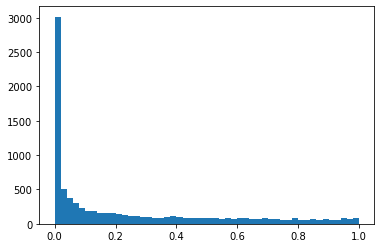

In [14]:
plt.figure()
plt.hist(pval_gen, 50)
plt.show()

Model resampling- bootstrapping

In [15]:
# Define function that can be called by each worker:
def bootstrap_model(variable, n_boot, dataset):    
    boot_stats = np.zeros((n_boot, 6))
    
    for boot_iter in range(n_boot):
        boot_sample = np.random.choice(dataset.shape[0], dataset.shape[0], replace=True)
        fm = dataset.columns[variable] + ' ~ C(Genotype) + C(Age)'
        mod = smf.ols(formula = fm, data=dataset.iloc[boot_sample, :])
        res = mod.fit()
        boot_stats[boot_iter, 0] = res.pvalues[1]
        boot_stats[boot_iter, 1] = res.pvalues[2]
        boot_stats[boot_iter, 2] = res.params[1]
        boot_stats[boot_iter, 3] = res.params[2]
        boot_stats[boot_iter, 4] = res.f_pvalue
        boot_stats[boot_iter, 5] = res.rsquared
    return boot_stats

In [18]:
import joblib
results = joblib.Parallel(n_jobs=8, verbose=5, pre_dispatch='1.5*n_jobs')(joblib.delayed(bootstrap_model)(i, 50, dataset) for  i in range(2, dataset.shape[1])) 

[Parallel(n_jobs=8)]: Done 4596 tasks      | elapsed: 39.6min


KeyboardInterrupt: ignored

In [19]:
# mean and standard deviation for regression coefficients and wald test p-values
# Genotype
mean_beta_gen = np.array([x[:, 2].mean() for x in results])
std_beta_gen = np.array([x[:, 2].std() for x in results])
mean_p_gen = np.array([x[:, 0].mean() for x in results])
std_p_gen = np.array([x[:, 0].std() for x in results])
# Age
mean_beta_age = np.array([x[:, 3].mean() for x in results])
std_beta_age = np.array([x[:, 3].std() for x in results])
mean_p_age = np.array([x[:, 1].mean() for x in results])
std_p_age = np.array([x[:, 1].std() for x in results])

NameError: ignored

#Visualization

In [20]:
# Visualization of regression coefficients with Bootstrap confidence intervals
Lineplot(mean=mean_beta_gen, error=std_beta_gen, xaxis=ppm)
# Run the following line instead if bootstrapping wasn't done
# Lineplot(mean=beta_gen, error=None, xaxis=ppm)
plt.gca().invert_xaxis()

NameError: ignored

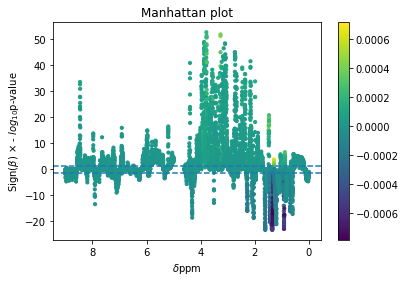

In [21]:
manhattan_plot(p_age_byadj, beta_age, xvalues=ppm)

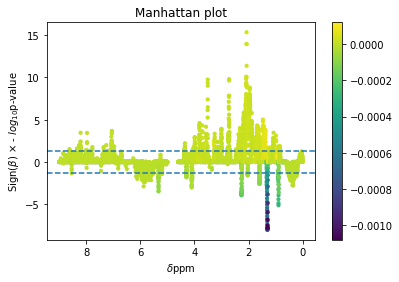

In [22]:
manhattan_plot(p_gen_byadj, beta_gen, xvalues=ppm)

In [24]:
iplot(interactive_manhattan(p_age_byadj, beta_age, sig=0.05, xvalues=ppm))